# Vehicle detection and tracking using image segmentation

In this project, We used annotated vehicle data set provided by Udacity: https://github.com/udacity/self-driving-car/tree/master/annotations. Then I trained a scaled down version of U-Net architecture. The input to U-net is a resized 960X640 3-channel RGB image and output is 960X640 1-channel mask of predictions.

There are some useful links which I used:
- https://github.com/jocicmarko/ultrasound-nerve-segmentation 
- https://github.com/vxy10/p5_VehicleDetection_Unet 
- https://handong1587.github.io/deep_learning/2015/10/09/segmentation.html

# Import libraries

In [1]:
### Import libraries
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import glob

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time
import pandas as pd
import csv

Using TensorFlow backend.


In [2]:
model_unet = 'non_batch_norm' #

# Import data

In [3]:
## Get path where files are to be stored
dir_label = ['object-dataset', 'object-detection-crowdai']

# some parameters
img_rows = 640
img_cols = 960
n_test = 3000

### Make data frame in Pandas

## read first dataset
df_files1 = pd.read_csv(dir_label[1]+'/labels_crowdai.csv', header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  dir_label[1] + '/' +df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)
df_vehicles1.head()

xmin  ymin  xmax  ymax                    Frame  Label  \
0   785   533   905   644  1479498371963069978.jpg    Car   
1    89   551   291   680  1479498371963069978.jpg    Car   
2   268   546   383   650  1479498371963069978.jpg    Car   
3   455   522   548   615  1479498371963069978.jpg  Truck   
4   548   522   625   605  1479498371963069978.jpg  Truck   

                                          File_Path  
0  object-detection-crowdai/1479498371963069978.jpg  
1  object-detection-crowdai/1479498371963069978.jpg  
2  object-detection-crowdai/1479498371963069978.jpg  
3  object-detection-crowdai/1479498371963069978.jpg  
4  object-detection-crowdai/1479498371963069978.jpg

In [4]:
## read second dataset
f = open(dir_label[0]+'/labels.csv', "r")
lines = f.read().split("\n") # "\r\n" if needed
Frame, xmin, ymin, xmax, ymax, ind, Label = [], [], [], [], [], [], []
for line in lines:
    if line != "": # add other needed checks to skip titles
        cols = line.split(" ")
        Frame.append(cols[0][1:])
        xmin.append(cols[1])
        xmax.append(cols[2])
        ymin.append(cols[3])
        ymax.append(cols[4])
        ind.append(cols[5])
        Label.append(cols[6][2:-3])

df_files2 = pd.DataFrame(data=np.transpose(np.array([Frame,xmin,xmax,ymin,ymax,ind,Label])))
df_files2.columns= ['Frame',  'xmin', 'ymin', 'xmax','ymax', 'ind', 'Label']
df_vehicles2 = df_files2[(df_files2['Label']=='car') | (df_files2['Label']=='truck')].reset_index()
df_vehicles2 = df_vehicles2.drop('index', 1)
df_vehicles2 = df_vehicles2.drop('ind', 1)
df_vehicles2['File_Path'] = dir_label[0] + '/' +df_vehicles2['Frame']
df_vehicles2 = df_vehicles2[['xmin','ymin','xmax', 'ymax','Frame', 'Label', 'File_Path']]
df_vehicles2['xmin'] = [int(tmp) for tmp in df_vehicles2['xmin']]
df_vehicles2['xmax'] = [int(tmp) for tmp in df_vehicles2['xmax']]
df_vehicles2['ymin'] = [int(tmp) for tmp in df_vehicles2['ymin']]
df_vehicles2['ymax'] = [int(tmp) for tmp in df_vehicles2['ymax']]
df_vehicles2.head()

xmin  ymin  xmax  ymax                    Frame  Label  \
0   950   574  1004   620  1478019952686311006.jpg    car   
1   872   586   926   632  1478019953180167674.jpg    car   
2   686   566   728   618  1478019953689774621.jpg  truck   
3   716   578   764   622  1478019953689774621.jpg    car   
4   826   580   880   626  1478019953689774621.jpg    car   

                                File_Path  
0  object-dataset/1478019952686311006.jpg  
1  object-dataset/1478019953180167674.jpg  
2  object-dataset/1478019953689774621.jpg  
3  object-dataset/1478019953689774621.jpg  
4  object-dataset/1478019953689774621.jpg

# Some helper functions

In [5]:
## some helper functions

def augment_brightness(image):
    ### Augment brightness
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1

def get_image_name(df, ind, size=(640, 300), augmentation=False):
    ### Get image by name
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    if augmentation == True:
        img = augment_brightness(img)

    bb_boxes['xmin'] = (bb_boxes['xmin'] / img_size[1] * img_size_post[1])
    bb_boxes['xmax'] = (bb_boxes['xmax'] / img_size[1] * img_size_post[1])
    bb_boxes['ymin'] = (bb_boxes['ymin'] / img_size[0] * img_size_post[0])
    bb_boxes['ymax'] = (bb_boxes['ymax'] / img_size[0] * img_size_post[0])
    bb_boxes['xmin'] = [int(tmp) for tmp in bb_boxes['xmin']]
    bb_boxes['xmax'] = [int(tmp) for tmp in bb_boxes['xmax']]
    bb_boxes['ymin'] = [int(tmp) for tmp in bb_boxes['ymin']]
    bb_boxes['ymax'] = [int(tmp) for tmp in bb_boxes['ymax']]
    bb_boxes['Area'] = (bb_boxes['xmax'] - bb_boxes['xmin']) * (bb_boxes['ymax'] - bb_boxes['ymin'])

    return name_str, img, bb_boxes

def get_mask_seg(img, bb_boxes_f):
    #### Get mask

    img_mask = np.zeros_like(img[:, :, 0])
    for i in range(len(bb_boxes_f)):
        bb_box_i = ([(bb_boxes_f.iloc[i]['xmin']), (bb_boxes_f.iloc[i]['ymin']),
                     (bb_boxes_f.iloc[i]['xmax']), (bb_boxes_f.iloc[i]['ymax'])])

        img_mask[bb_box_i[1]:bb_box_i[3], bb_box_i[0]:bb_box_i[2]] = 1
        img_mask = np.reshape(img_mask, (np.shape(img_mask)[0], np.shape(img_mask)[1], 1))
    return img_mask

def plot_im_mask(im, im_mask,bbox):
    ### Function to plot image mask

    im = np.array(im, dtype=np.uint8)
    im_mask = np.array(im_mask, dtype=np.uint8)
    plt.subplot(1, 3, 1)
    plot_im_bbox(im, bbox)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(im_mask[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.bitwise_and(im, im, mask=im_mask));
    plt.axis('off')
    plt.show();

def plot_bbox(bb_boxes, ind_bb, color='r', linewidth=2):
    ### Plot bounding box

    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0], bb_box_i[2], bb_box_i[2],
              bb_box_i[0], bb_box_i[0]],
             [bb_box_i[1], bb_box_i[1], bb_box_i[3],
              bb_box_i[3], bb_box_i[1]],
             color, linewidth=linewidth)

def plot_im_bbox(im, bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes, i, 'g')

        bb_box_i = ([(bb_boxes.iloc[i]['xmin']), (bb_boxes.iloc[i]['ymin']),
                     (bb_boxes.iloc[i]['xmax']), (bb_boxes.iloc[i]['ymax'])])
        plt.plot(bb_box_i[0], bb_box_i[1])
        plt.plot(bb_box_i[2], bb_box_i[3])
    plt.axis('off');

#### Training generator, generates augmented images
def generate_train_batch(data, batch_size=32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while True:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data) - n_test)
            name_str, img, bb_boxes = get_image_name(df_vehicles, i_line, size=(img_cols, img_rows), augmentation=True)
            img_mask = get_mask_seg(img, bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] = img_mask
        yield batch_images, batch_masks

#### Testing generator, generates augmented images
def generate_test_batch(data, batch_size=32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while True:
        for i_batch in range(batch_size):
            i_line = np.random.randint(n_test)
            i_line = i_line + len(data) - n_test
            name_str, img, bb_boxes = get_image_name(df_vehicles, i_line, size=(img_cols, img_rows), augmentation=False)
            img_mask = get_mask_seg(img, bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] = img_mask
        yield batch_images, batch_masks

### IOU or dice coeff calculation
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2 * (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

### Defining a small Unet
### Smaller Unet defined so it fits in memory
def get_unet():
    if model_unet != 'batch_norm':
        inputs = Input((img_rows, img_cols, 3))
        conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
        conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
        conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
        conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
        conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
        conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

        up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
        conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
        conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

        up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
        conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
        conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

        up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
        conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
        conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

        up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
        conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
        conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

        conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

        model = Model(input=inputs, output=conv10)

        return model
    
    elif model_unet == 'batch_norm':
        inputs = Input((img_rows, img_cols, 3))    
        conv1 = Convolution2D(8, 3, 3, border_mode='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)

        conv1 = Convolution2D(8, 3, 3, border_mode='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Convolution2D(16, 3, 3, border_mode='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)


        conv2 = Convolution2D(16, 3, 3, border_mode='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Convolution2D(32, 3, 3, border_mode='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation('relu')(conv3)


        conv3 = Convolution2D(32, 3, 3, border_mode='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation('relu')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Convolution2D(64, 3, 3, border_mode='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation('relu')(conv4)

        conv4 = Convolution2D(64, 3, 3, border_mode='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation('relu')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Convolution2D(128, 3, 3, border_mode='same')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation('relu')(conv5)

        conv5 = Convolution2D(128, 3, 3, border_mode='same')(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation('relu')(conv5)

        up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
        conv6 = Convolution2D(64, 3, 3, border_mode='same')(up6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation('relu')(conv6)

        conv6 = Convolution2D(64, 3, 3, border_mode='same')(conv6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation('relu')(conv6)

        up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
        conv7 = Convolution2D(32, 3, 3, border_mode='same')(up7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation('relu')(conv7)

        conv7 = Convolution2D(32, 3, 3, border_mode='same')(conv7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation('relu')(conv7)

        up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
        conv8 = Convolution2D(16, 3, 3, border_mode='same')(up8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation('relu')(conv8)


        conv8 = Convolution2D(16, 3, 3, border_mode='same')(conv8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation('relu')(conv8)

        up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
        conv9 = Convolution2D(8, 3, 3, border_mode='same')(up9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation('relu')(conv9)

        conv9 = Convolution2D(8, 3, 3, border_mode='same')(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation('relu')(conv9)

        conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

        model = Model(input=inputs, output=conv10)

        return model

#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


# Plot some images

### Dataframe #1

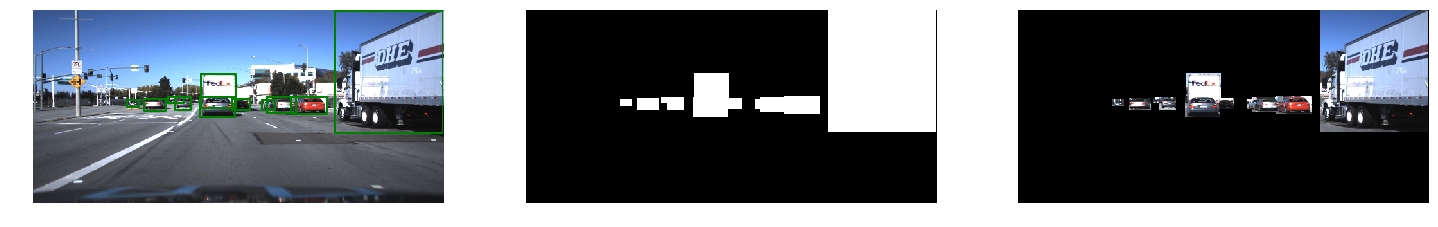

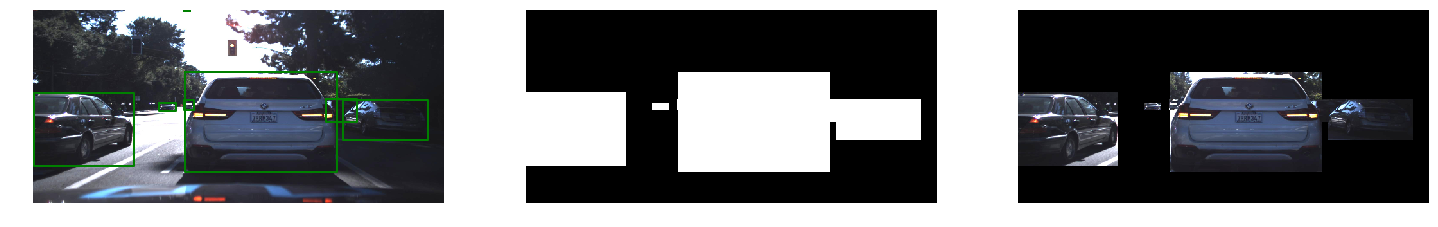

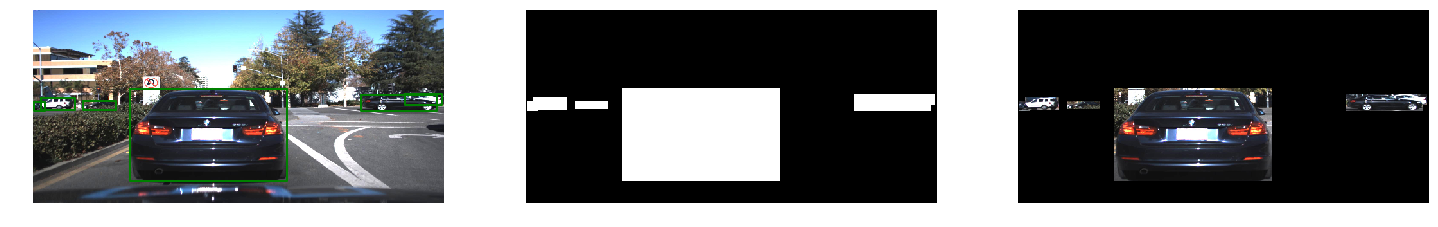

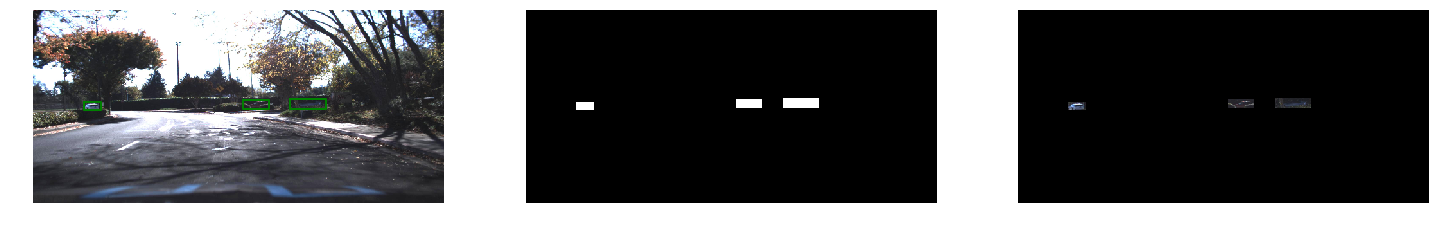

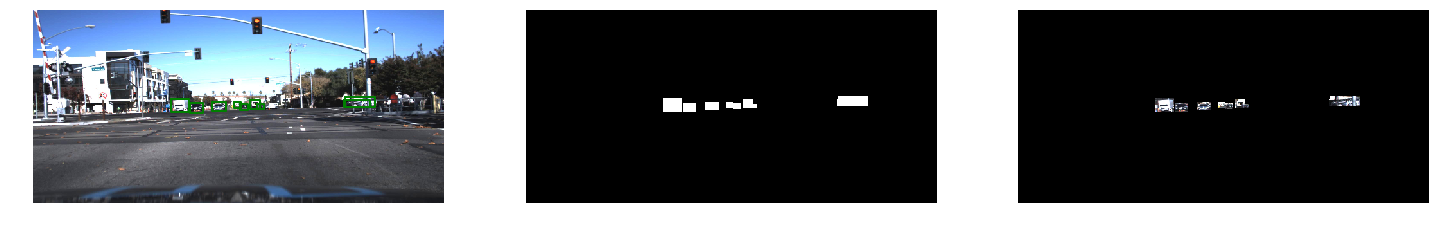

In [6]:
for i in range(5):
    plt.figure(figsize=(25,20))
    name, img_df1, bbox1 = get_image_name(df_vehicles1, np.random.randint(0, len(df_vehicles1)))
    img_df1_msk = get_mask_seg(img_df1, bbox1)
    plot_im_mask(img_df1, img_df1_msk, bbox1)

### Dataframe #2

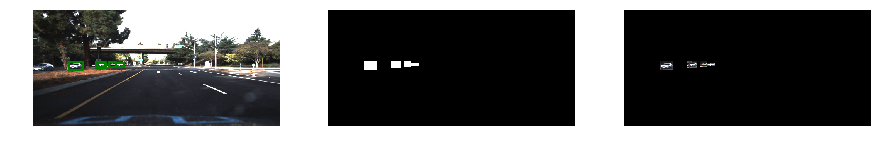

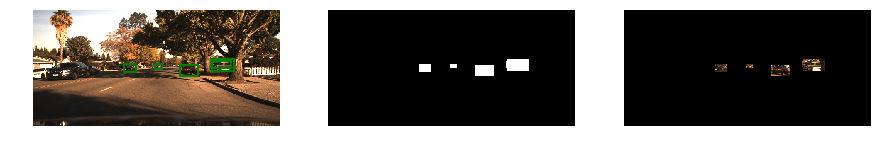

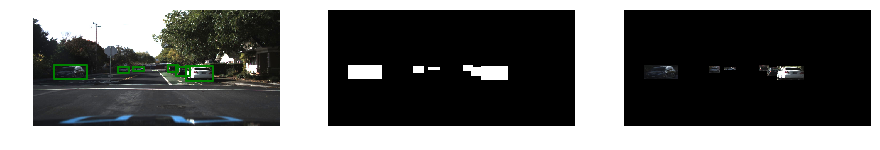

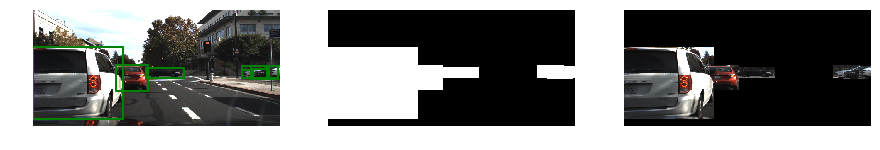

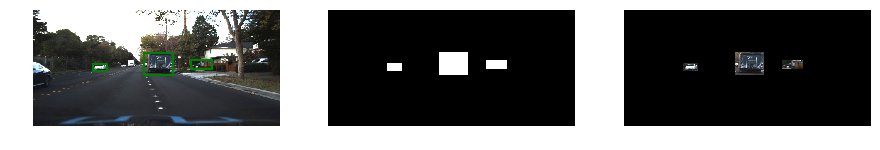

In [7]:
for i in range(5):
    plt.figure(figsize=(15,10))
    name, img_df2, bbox2 = get_image_name(df_vehicles2, np.random.randint(0, len(df_vehicles2)))
    img_df2_msk = get_mask_seg(img_df2, bbox2)
    plot_im_mask(img_df2, img_df2_msk, bbox2)

# Concatenate two dataframes

In [8]:
### Combine two data frames
df_vehicles = pd.concat([df_vehicles1,df_vehicles2]).reset_index()
df_vehicles = df_vehicles.drop('index', 1)
df_vehicles.head()

xmin  ymin  xmax  ymax                    Frame  Label  \
0   785   533   905   644  1479498371963069978.jpg    Car   
1    89   551   291   680  1479498371963069978.jpg    Car   
2   268   546   383   650  1479498371963069978.jpg    Car   
3   455   522   548   615  1479498371963069978.jpg  Truck   
4   548   522   625   605  1479498371963069978.jpg  Truck   

                                          File_Path  
0  object-detection-crowdai/1479498371963069978.jpg  
1  object-detection-crowdai/1479498371963069978.jpg  
2  object-detection-crowdai/1479498371963069978.jpg  
3  object-detection-crowdai/1479498371963069978.jpg  
4  object-detection-crowdai/1479498371963069978.jpg

# Compile model and load weights

In [9]:
### Generator
training_gen = generate_train_batch(df_vehicles,1)
smooth = 1.
model = get_unet()
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [10]:
### Using previously trained data. Set load_pretrained = False, increase epochs and train for full training.
load_pretrained = True
Training = False

if load_pretrained == True:
    print("loading weights ...")
    if model_unet == 'batch_norm':
#         model.load_weights("model_detect_Unet_BN_5000.h5")
        model.load_weights("model_detect_SmallUnet.h5")
        print('U-Net weights with batch normalization layers loaded')
    else:
    #     model.load_weights("model_segn_small_0p72.h5")
        model.load_weights("model_detect_SmallUnet_BN.h5")
        print('U-Net weights without batch normalization layers loaded')
if Training == True:
    print('training the model ...')
    history = model.fit_generator(training_gen, samples_per_epoch=1000, nb_epoch=10)
    model.save('model_detect_SmallUnet.h5')
    print('training finished!!')


loading weights ...
U-Net weights without batch normalization layers loaded


In [11]:
if Training==True:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['IOU_calc'])
    # plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Test trained model

In [12]:
### Testing generator
testing_gen = generate_test_batch(df_vehicles,5)

### Test on last frames of data
batch_img, batch_mask = next(testing_gen)
pred_all = model.predict(batch_img)
batch_img.shape , batch_mask.shape , pred_all.shape

((5, 640, 960, 3), (5, 640, 960, 1), (5, 640, 960, 1))

In [13]:
batch_mask[0].max() , pred_all[0].max()

(1.0, 1.0)

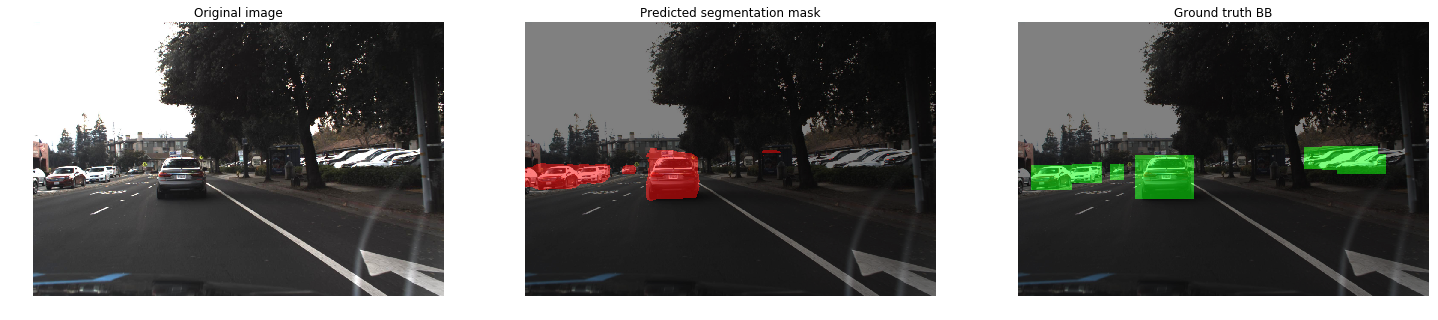

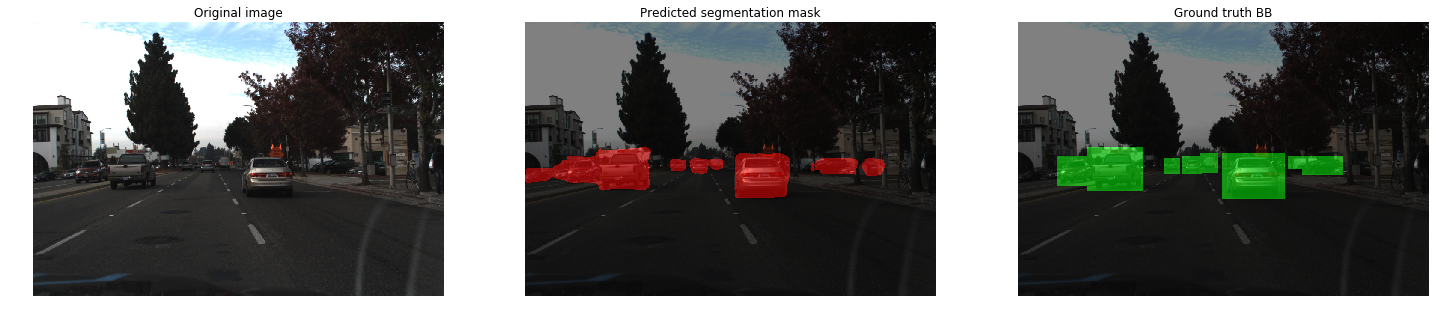

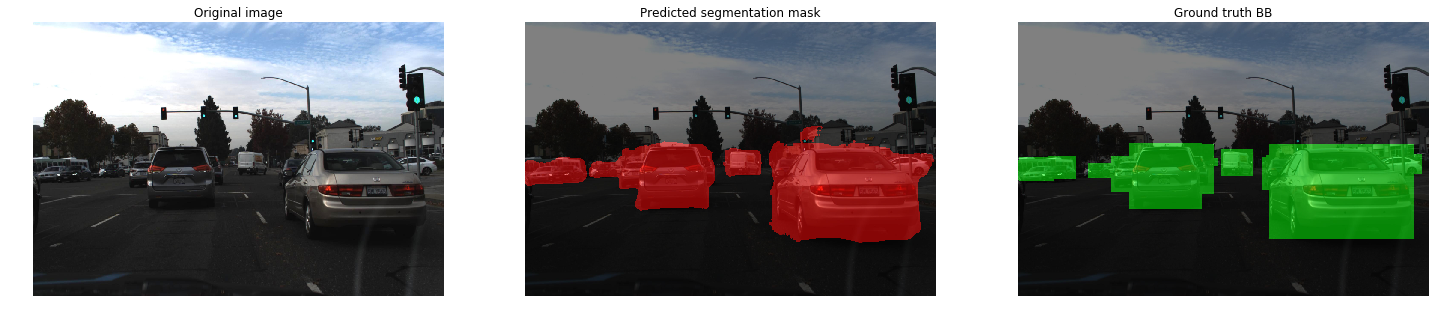

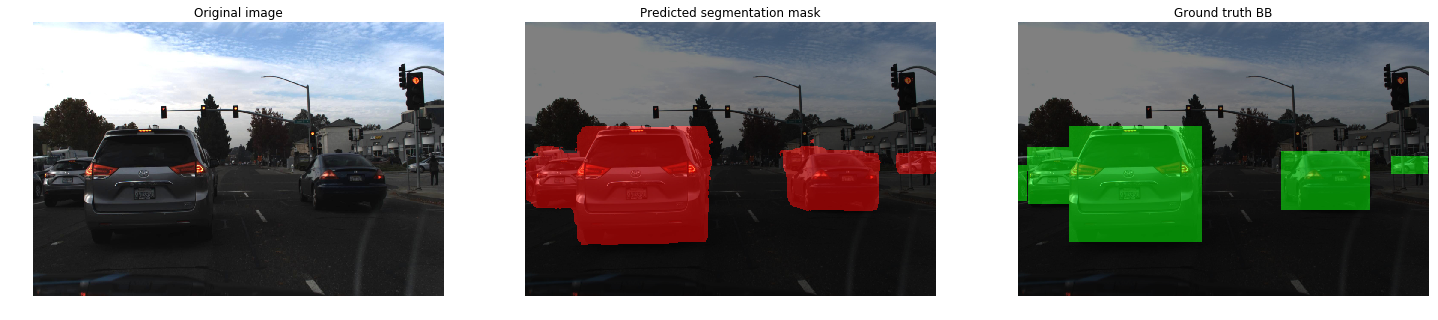

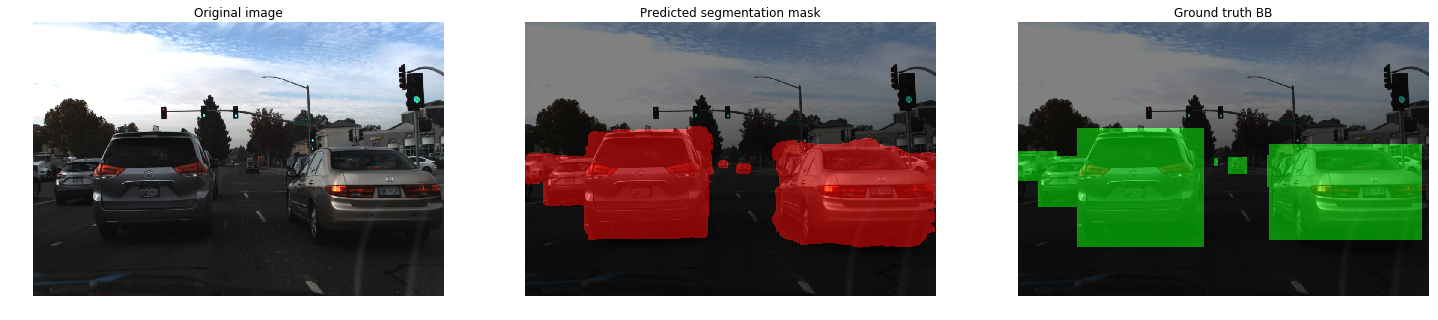

In [14]:

for i in range(5):
    im = np.array(batch_img[i], dtype=np.uint8)
    im_mask = np.array(255 * batch_mask[i], dtype=np.uint8)
    im_pred = np.array(255 * pred_all[i], dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:, :, 1] = 0 * rgb_mask_pred[:, :, 1]  # predictions are red
    rgb_mask_pred[:, :, 2] = 0 * rgb_mask_pred[:, :, 2]
    rgb_mask_true = cv2.cvtColor(im_mask, cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:, :, 0] = 0 * rgb_mask_true[:, :, 0]  # ground truthes are green
    rgb_mask_true[:, :, 2] = 0 * rgb_mask_true[:, :, 2]

    img_pred = cv2.addWeighted(rgb_mask_pred, 0.5, im, 0.5, 0)
    img_true = cv2.addWeighted(rgb_mask_true, 0.5, im, 0.5, 0)

    plt.figure(figsize=(25, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()


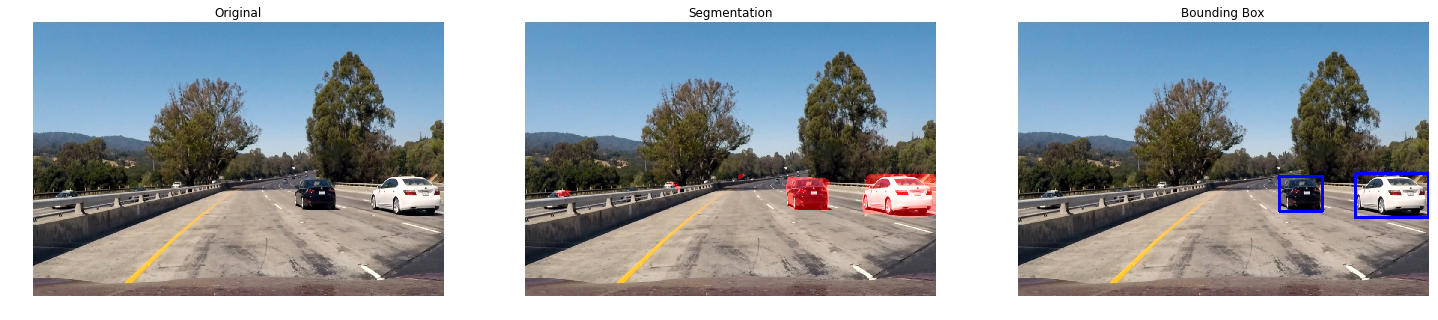

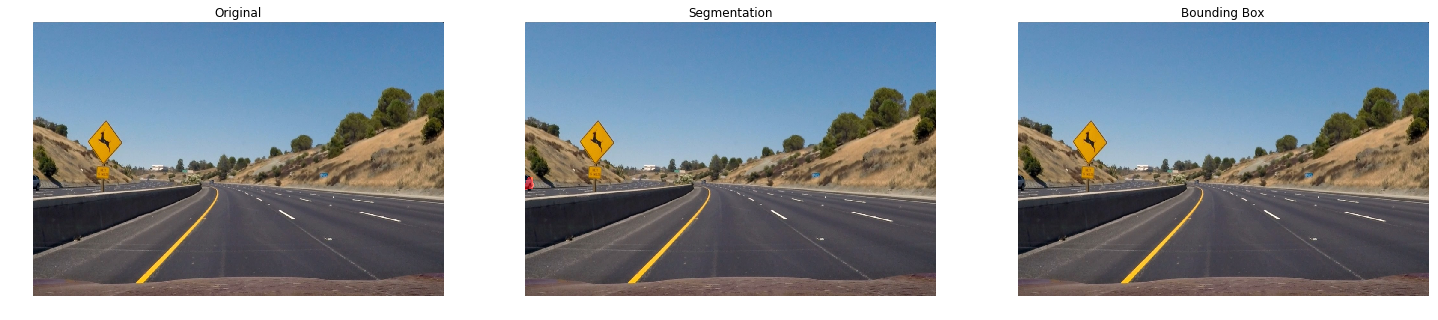

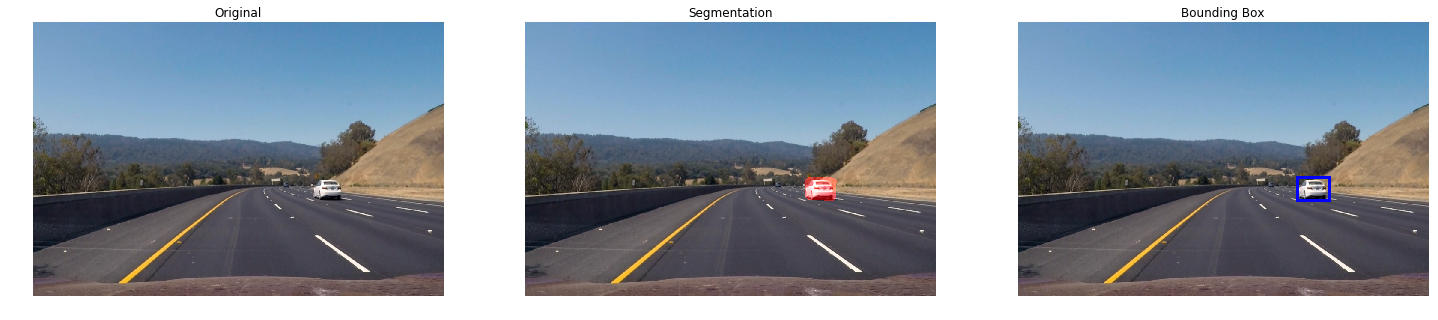

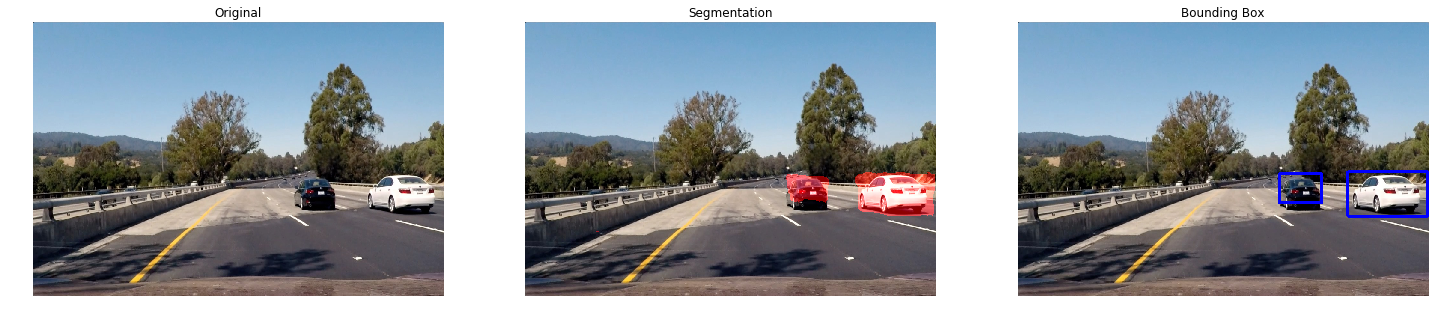

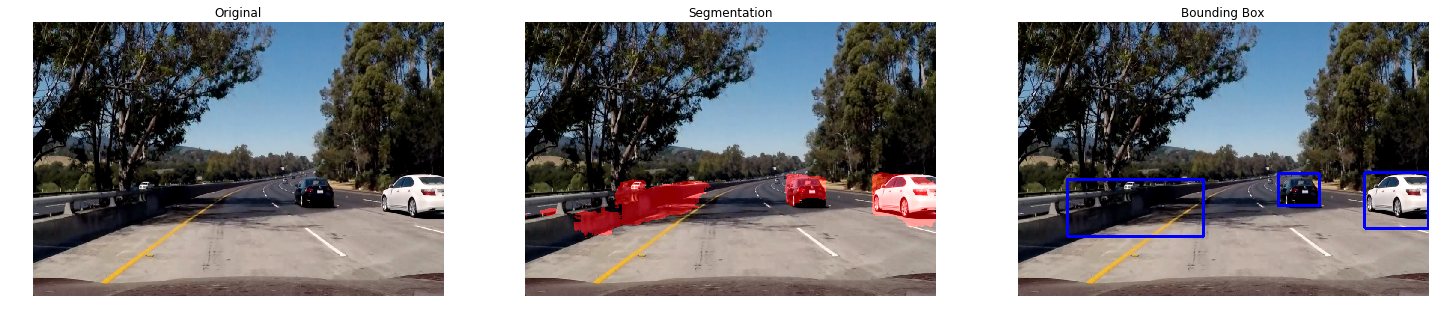

In [15]:
## test on some images
for i in range(5):
    test_img = 'test_images/test'+str(i+1)+'.jpg'
    im = cv2.imread(test_img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    pred,im = test_new_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:, :, 1] = 0 * rgb_mask_pred[:, :, 1]  # predictions are red
    rgb_mask_pred[:, :, 2] = 0 * rgb_mask_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)

    draw_img = get_BB_new_img(im)

    plt.figure(figsize=(25,20))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Segmentation')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');
    plt.show()

# Apply pipeline on video

In [18]:
def pipeline(image):
    img = np.copy(image)
    pred,im = test_new_img(img)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:, :, 1] = 0 * rgb_mask_pred[:, :, 1]  # predictions are red
    rgb_mask_pred[:, :, 2] = 0 * rgb_mask_pred[:, :, 2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)
    
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    img = cv2.resize(img,(img_cols, img_rows))
#     img = np.reshape(img,(1,img_rows, img_cols,3))
    draw_img = draw_labeled_bboxes(img, labels)
    
#     return img_pred
    return draw_img

In [19]:
from moviepy.editor import VideoFileClip

# Convert to video
# vid_output is where the image will be saved to
vid_output = 'vehicle_detection_uNet.mp4'
# vid_output = 'vehicle_detection_uNet_bbox_BN.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("project_video.mp4").subclip(0,30)
# clip1 = VideoFileClip("challenge_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline) 
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video vehicle_detection_uNet.mp4
[MoviePy] Writing video vehicle_detection_uNet.mp4



  9%|███████▏                                                                         | 67/751 [00:07<01:14,  9.18it/s]


 18%|██████████████▍                                                                 | 135/751 [00:15<01:12,  8.52it/s]


 27%|█████████████████████▌                                                          | 203/751 [00:23<01:03,  8.63it/s]


 36%|████████████████████████████▊                                                   | 271/751 [00:31<00:57,  8.42it/s]


 45%|████████████████████████████████████                                            | 339/751 [00:39<00:48,  8.55it/s]


 54%|███████████████████████████████████████████▎                                    | 407/751 [00:47<00:40,  8.54it/s]


 63%|██████████████████████████████████████████████████▌                             | 475/751 [00:55<00:32,  8.52it/s]


 72%|█████████████████████████████████████████████████████████▊                      | 543/751 [01:03<00:25,  8.21it/s]


 81%|█████████████████████████████████████████████████████████████████               | 611/751 [01:12<00:20,  6.97it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 679/751 [01:20<00:08,  8.22it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 747/751 [01:29<00:00,  8.21it/s]


100%|███████████████████████████████████████████████████████████████████████████████▉| 750/751 [01:30<00:00,  8.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection_uNet.mp4 

Wall time: 1min 30s
